In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from torchsummary import summary
torch.__version__

'2.8.0+cu126'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [4]:
set_seed()

In [5]:
df = pd.read_excel('/kaggle/input/tc-lstm/TC_Data_LSTM.xlsx')
date = pd.to_datetime(df['Date'],dayfirst=True)
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

In [6]:
df.head(12)

,Date,aet,ppt,ro,srad,soilm,tavg,g_wa
0,1990-01-01,10.2085,1.0000,0.0000,192.7015,35.6984,19.99850,16.07
1,1990-02-01,16.1381,10.2768,0.6384,210.6888,29.5871,21.09425,15.58
2,1990-03-01,6.0153,2.0000,0.0000,259.2214,25.3212,24.84405,14.20
3,1990-04-01,3.1799,0.0000,0.0000,286.2422,22.1745,31.03615,11.06
4,1990-05-01,28.4456,27.3566,1.0135,257.8285,19.7246,32.56040,12.30
5,1990-06-01,177.8275,190.4066,9.4933,206.6860,22.8160,29.78505,11.40
6,1990-07-01,107.2188,492.2677,217.6124,140.8859,190.3516,25.44210,15.98
7,1990-08-01,99.3405,440.4058,341.1260,163.9127,190.3516,25.75670,14.31
8,1990-09-01,99.2207,324.3730,225.1714,150.1706,190.3516,25.59215,25.46
9,1990-10-01,82.3771,16.5122,1.0000,213.3591,123.6047,25.23340,22.86


In [7]:
water_area = df['g_wa']
X_data = df.drop(columns=['Date','ro','srad']).to_numpy()
variable=X_data.shape[1]
y_data = df['g_wa'].to_numpy().reshape(-1,1)
variable=X_data.shape[1]
variable

5

In [8]:
# from sklearn.preprocessing import StandardScaler
# scaler1 = StandardScaler()
# scaler2 = StandardScaler()
# X = scaler1.fit_transform(X_data)
# y = scaler2.fit_transform(y_data.reshape(-1,1))
# X = X_data
# y = y_data

In [9]:
def sequence(ar1,seq):
    ln = ar1.shape[0]
    vr = ar1.shape[1]
    data_x = np.empty((ln-seq,seq,vr))
    for i in range(0,ln-seq):
        data_x[i] = ar1[i:i+seq]
    return data_x

In [10]:
X_seq=sequence(X_data,6)
y_seq = y_data[6:].reshape(-1,1)
X_seq.shape,y_seq.shape

((378, 6, 5), (378, 1))

In [11]:
torch_X_data = torch.tensor(X_seq).float().to(device)

In [12]:
val_split = int(0.75*X_data.shape[0])
X_train,X_test = X_seq[:val_split],X_seq[val_split:]

y_train,y_test = y_seq[:val_split],y_seq[val_split:]
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((288, 6, 5), (90, 6, 5), (288, 1), (90, 1))

In [13]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([288, 6, 5]),
 torch.Size([90, 6, 5]),
 torch.Size([288, 1]),
 torch.Size([90, 1]))

In [14]:
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [15]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
class WA_LSTM(nn.Module):
    def __init__(self, in_size, hidden_units_lstm, hidden_units, dropout):
        super().__init__()
        self.in_size = in_size
        self.hidden_units_lstm = hidden_units_lstm
        self.hidden_units = hidden_units
        self.dropout = dropout
        self.lstm1 = nn.LSTM(in_size, hidden_units_lstm, 1, batch_first=True)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_units_lstm, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h01 = torch.zeros(1, batch_size, self.hidden_units_lstm).to(device)
        c01 = torch.zeros(1, batch_size, self.hidden_units_lstm).to(device)

        out, _ = self.lstm1(x, (h01, c01))
        
        out = out[:, -1, :]
        out = self.act1(out)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
#         out = F.softplus(out)
        return out

In [17]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

# Model Parameters
input_size = variable
hidden_units_lstm = 96
hidden_units = 80
dropout = 0.04
wd = 0.02
learning_rate = 0.00026169952537910714
lstm_model = WA_LSTM(input_size, hidden_units_lstm, hidden_units, dropout).to(device)
lstm_model

WA_LSTM(
  (lstm1): LSTM(5, 96, batch_first=True)
  (act1): ReLU()
  (dropout): Dropout(p=0.04, inplace=False)
  (fc1): Linear(in_features=96, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=1, bias=True)
)

In [18]:
from torchinfo import summary
summary(lstm_model, (1,4,5))

Layer (type:depth-idx)                   Output Shape              Param #
WA_LSTM                                  [1, 1]                    --
├─LSTM: 1-1                              [1, 4, 96]                39,552
├─ReLU: 1-2                              [1, 96]                   --
├─Dropout: 1-3                           [1, 96]                   --
├─Linear: 1-4                            [1, 80]                   7,760
├─Linear: 1-5                            [1, 1]                    81
Total params: 47,393
Trainable params: 47,393
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.19

In [19]:
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate, weight_decay = wd)
# Training Loop
epochs = 150
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training
    lstm_model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = lstm_model(X_batch)
        loss = loss_fn(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Testing
    lstm_model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = lstm_model(X_batch)
            loss = loss_fn(predictions, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/150, Train Loss: 19.4794, Test Loss: 20.1149
Epoch 2/150, Train Loss: 12.7750, Test Loss: 9.7309
Epoch 3/150, Train Loss: 5.6945, Test Loss: 5.8676
Epoch 4/150, Train Loss: 4.1036, Test Loss: 4.8752
Epoch 5/150, Train Loss: 3.6720, Test Loss: 4.3283
Epoch 6/150, Train Loss: 3.2640, Test Loss: 3.9359
Epoch 7/150, Train Loss: 3.1969, Test Loss: 4.0257
Epoch 8/150, Train Loss: 2.9278, Test Loss: 3.7579
Epoch 9/150, Train Loss: 3.0122, Test Loss: 3.4967
Epoch 10/150, Train Loss: 2.6780, Test Loss: 3.5446
Epoch 11/150, Train Loss: 2.6829, Test Loss: 3.0506
Epoch 12/150, Train Loss: 2.7477, Test Loss: 3.5609
Epoch 13/150, Train Loss: 2.5849, Test Loss: 3.4362
Epoch 14/150, Train Loss: 2.5890, Test Loss: 3.0932
Epoch 15/150, Train Loss: 2.5057, Test Loss: 2.7668
Epoch 16/150, Train Loss: 2.4653, Test Loss: 2.7124
Epoch 17/150, Train Loss: 2.3521, Test Loss: 2.7739
Epoch 18/150, Train Loss: 2.4881, Test Loss: 2.6044
Epoch 19/150, Train Loss: 2.4161, Test Loss: 2.8477
Epoch 20/150, Trai

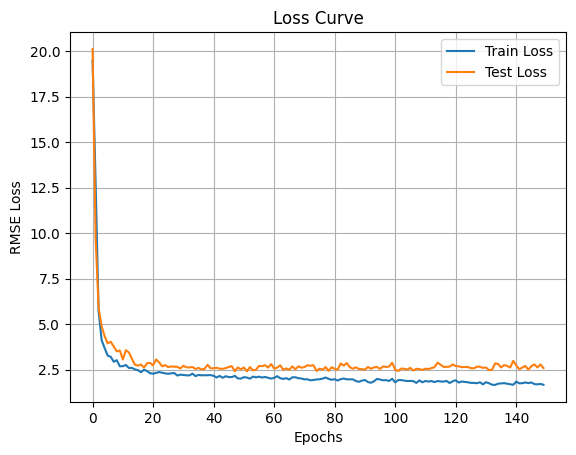

In [20]:
# Plot Loss Curve
# plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
# plt.show()


In [21]:
predicted_y = lstm_model(torch_X_data).detach().cpu().numpy()
# pred_wa = scaler2.inverse_transform(predicted_y)
pred_wa = predicted_y
wa = y_data[6:].reshape(-1,1)

Text(0.01, 0.95, '(d)')

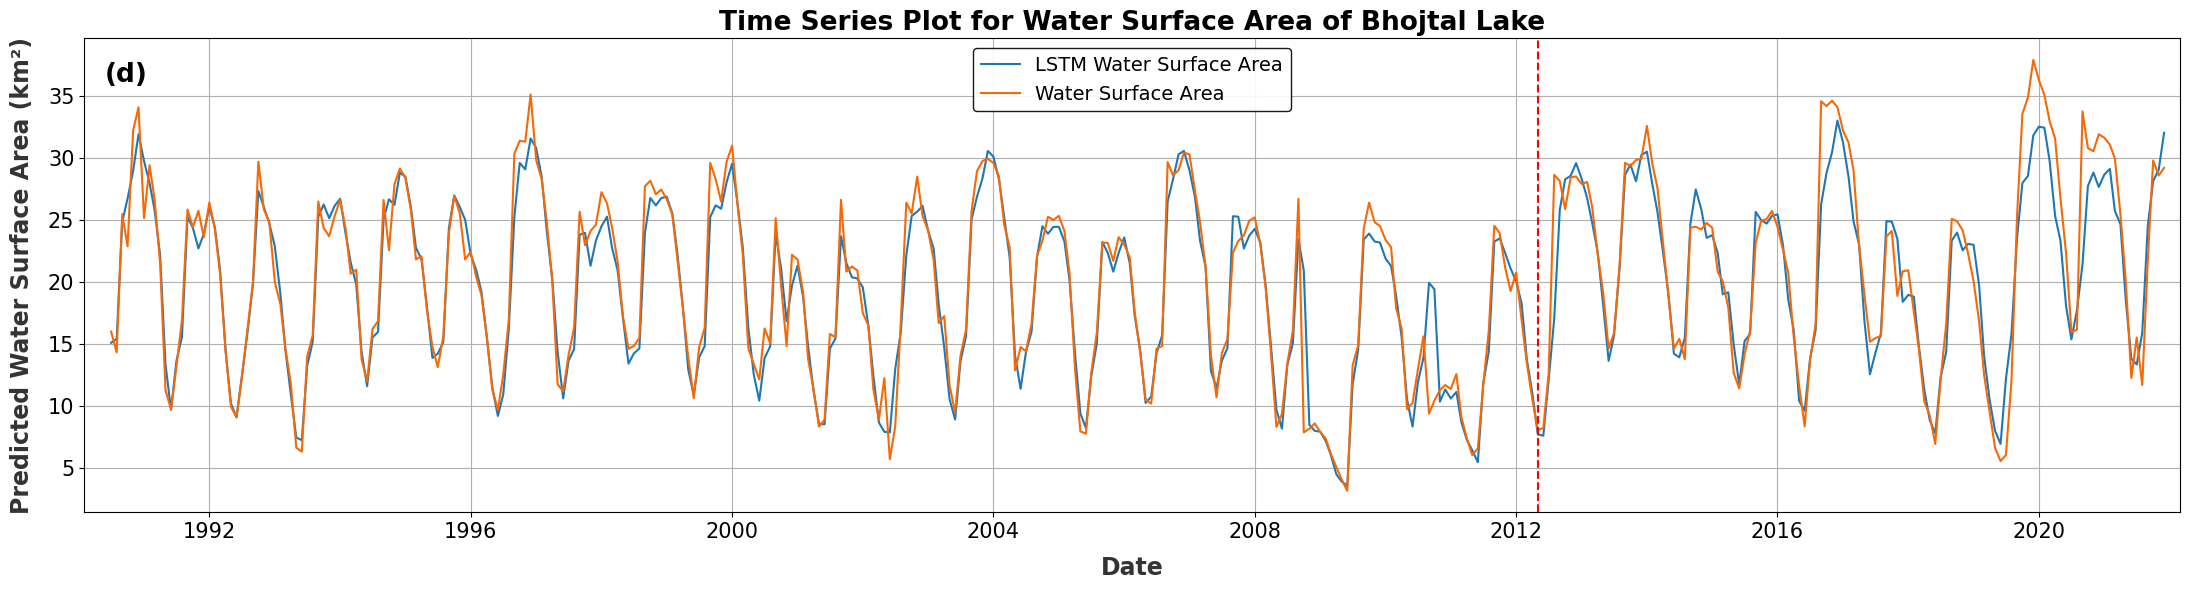

In [22]:
plt.figure(figsize=(22, 6))
plt.plot(date[6:], pred_wa, label='LSTM Water Surface Area')
plt.plot(date[6:], wa, label='Water Surface Area',color = '#F76806')
plt.xlabel("Date", fontsize=17, fontweight='bold', color='#333333', labelpad=10)
plt.ylabel("Predicted Water Surface Area (km²)", fontsize=17, fontweight='bold', color='#333333', labelpad=10)
plt.title('Time Series Plot for Water Surface Area of Bhojtal Lake',fontsize=19, fontweight='bold')

x_start = '1990-01-31'
x_end = '2022-02-28'
plt.xlim(pd.to_datetime(x_start), pd.to_datetime(x_end))

split_index = int(len(date) * 0.70)
split_date = pd.to_datetime(date[split_index])
plt.axvline(split_date, color='red', linestyle='--')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.legend(
    fontsize=14, loc='upper center', frameon=True, facecolor='white', edgecolor='black', framealpha=0.9)
plt.tight_layout()
plt.text(0.01, 0.95, '(d)', transform=plt.gca().transAxes,
         fontsize=19, fontweight='bold', va='top', ha='left')
# plt.savefig(r'C:\Users\hp\Roshan MS Work\MS Thesis\fig\LSTMfig1.jpg',dpi = 600)


In [23]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
mse = mean_squared_error(wa,pred_wa)
rmse = np.sqrt(mse)
mae = mean_absolute_error(wa,pred_wa)
r2 = r2_score(wa,pred_wa)

In [24]:
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R\u00b2: {r2:.4f}")

RMSE: 2.2276
MAE: 1.4280
MSE: 4.9622
R²: 0.9118


In [25]:

train_predicted_y = lstm_model(X_train.to(device)).detach().cpu().numpy()
train_pred_wa = train_predicted_y
train_wa = y_train.detach().cpu().numpy()

Text(0.01, 0.99, '(a)')

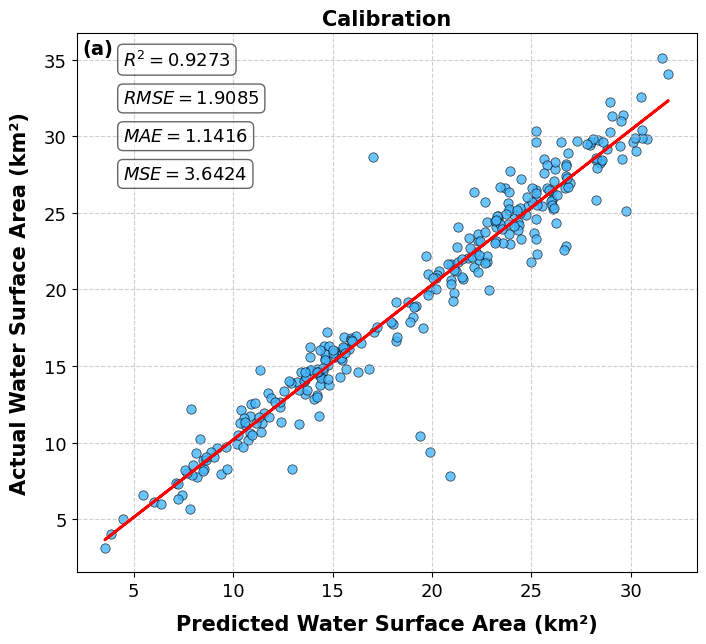

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Example data
x = train_pred_wa
y = train_wa

# Reshape x for sklearn (needs to be 2D)
x = x.reshape(-1, 1)

# Linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Calculate metrics
r2 = r2_score(y, x)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Plot improvements
plt.figure(figsize=(8, 7))
plt.rcParams["font.family"] = "DejaVu Sans"

# Scatter plot with transparency
plt.scatter(x, y,color='#45b6fe', s=45, alpha=0.8, edgecolors='black', linewidth=0.5)

# Regression line
plt.plot(x, y_pred, color='red', linewidth=2, linestyle='solid')

# Text annotations with improved aesthetics
text_props = dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle="round,pad=0.3")
plt.text(0.075, 0.94, f'$R^2 = {r2:.4f}$', transform=plt.gca().transAxes, fontsize=13, bbox=text_props)
plt.text(0.075, 0.87, f'$RMSE = {rmse:.4f}$', transform=plt.gca().transAxes, fontsize=13, bbox=text_props)
plt.text(0.075, 0.8, f'$MAE = {mae:.4f}$', transform=plt.gca().transAxes, fontsize=13, bbox=text_props)
plt.text(0.075, 0.73, f'$MSE = {mse:.4f}$', transform=plt.gca().transAxes, fontsize=13, bbox=text_props)

# Labels with improved font size and readability
plt.xlabel('Predicted Water Surface Area (km²)', fontsize=15, fontweight='bold', labelpad=10)
plt.ylabel('Actual Water Surface Area (km²)', fontsize=15, fontweight='bold', labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Grid with better styling
plt.grid(True, linestyle='--', alpha=0.6)
plt.title('Calibration',fontsize=15, fontweight='bold')
# Show legend
# plt.legend(fontsize=12, loc='upper left')
plt.text(0.01, 0.99, '(a)', transform=plt.gca().transAxes,
         fontsize=14, fontweight='bold', va='top', ha='left')
# Display the plot
# plt.savefig(r'C:\Users\hp\Roshan MS Work\MS Thesis\fig\calibration_scatter_lstm.jpg',dpi=600)

In [27]:
val_predicted_y = lstm_model(X_test.to(device)).detach().cpu().numpy()
# test_pred_wa = scaler2.inverse_transform(val_predicted_y)
test_pred_wa = val_predicted_y
test_wa = y_test.detach().cpu().numpy().reshape(-1,1)
# test_wa = scaler2.inverse_transform(test_wa)

In [28]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
mse = mean_squared_error(test_wa,test_pred_wa)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_wa,test_pred_wa)
r2 = r2_score(test_wa,test_pred_wa)

In [29]:
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R\u00b2: {r2:.4f}")

RMSE: 2.9830
MAE: 2.2045
MSE: 8.8985
R²: 0.8691


Text(0.01, 0.99, '(b)')

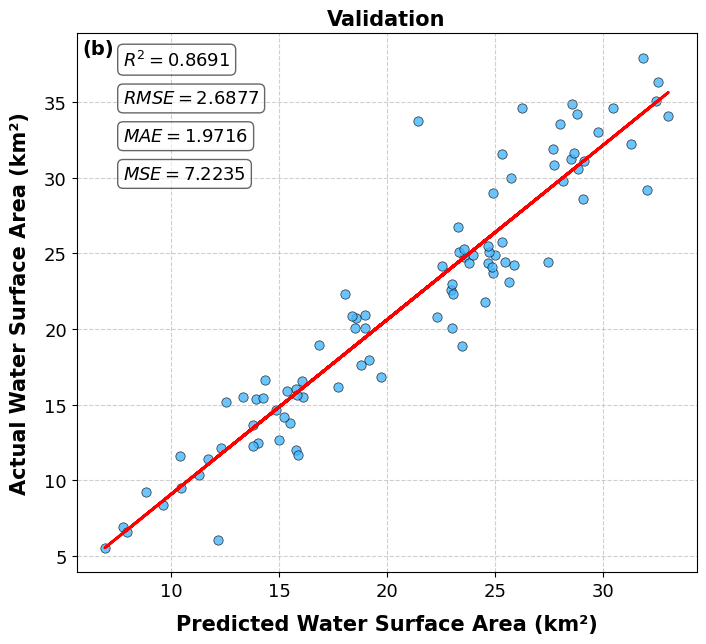

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Example data
x = test_pred_wa
y = test_wa

# Reshape x for sklearn (needs to be 2D)
x = x.reshape(-1, 1)

# Linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Calculate metrics
r2 = r2_score(y, x)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Plot improvements
plt.figure(figsize=(8, 7))
plt.rcParams["font.family"] = "DejaVu Sans"

# Scatter plot with transparency
plt.scatter(x, y,color='#45b6fe', s=45, alpha=0.8, edgecolors='black', linewidth=0.5)

# Regression line
plt.plot(x, y_pred, color='red', linewidth=2, linestyle='solid')

# Text annotations with improved aesthetics
text_props = dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle="round,pad=0.3")
plt.text(0.075, 0.94, f'$R^2 = {r2:.4f}$', transform=plt.gca().transAxes, fontsize=13, bbox=text_props)
plt.text(0.075, 0.87, f'$RMSE = {rmse:.4f}$', transform=plt.gca().transAxes, fontsize=13, bbox=text_props)
plt.text(0.075, 0.8, f'$MAE = {mae:.4f}$', transform=plt.gca().transAxes, fontsize=13, bbox=text_props)
plt.text(0.075, 0.73, f'$MSE = {mse:.4f}$', transform=plt.gca().transAxes, fontsize=13, bbox=text_props)

# Labels with improved font size and readability
plt.xlabel('Predicted Water Surface Area (km²)', fontsize=15, fontweight='bold', labelpad=10)
plt.ylabel('Actual Water Surface Area (km²)', fontsize=15, fontweight='bold', labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Grid with better styling
plt.grid(True, linestyle='--', alpha=0.6)
plt.title('Validation',fontsize=15, fontweight='bold')
# Show legend
# plt.legend(fontsize=12, loc='upper left')
plt.text(0.01, 0.99, '(b)', transform=plt.gca().transAxes,
         fontsize=14, fontweight='bold', va='top', ha='left')
# Display the plot
# plt.savefig(r'C:\Users\hp\Roshan MS Work\MS Thesis\fig\validation_scatter_lstm.jpg',dpi=600)

In [31]:
predicted_y = lstm_model(torch_X_data.to(device)).detach().cpu().numpy()
# test_pred_wa = scaler2.inverse_transform(val_predicted_y)
pred_wa = predicted_y
act_wa = y_seq
# test_wa = scaler2.inverse_transform(test_wa)

In [32]:
test_idx = list(range(289, 379))

R²   : 0.9166
RMSE : 2.1664
MAE  : 1.3766
MSE  : 4.6931


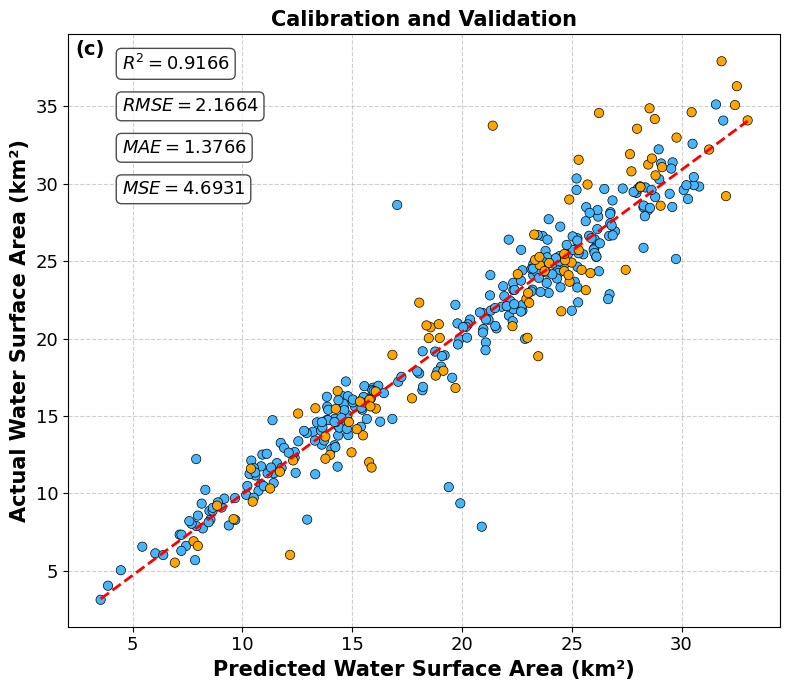

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


x = np.asarray(pred_wa).reshape(-1, 1)
y = np.asarray(act_wa)

# ------------------------------------------------------------------
# LINEAR REGRESSION (Calibration Line)
# ------------------------------------------------------------------
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# ------------------------------------------------------------------
# METRICS (CORRECT)
# ------------------------------------------------------------------
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")

# ------------------------------------------------------------------
# COLOR HANDLING (SAFE)
# ------------------------------------------------------------------
color1 = ['#45b6fe'] * len(x)  # calibration (blue)

if 'test_idx' in globals():
    for idx in test_idx:
        if idx < len(color1):
            color1[idx] = 'orange'  # validation/test (orange)

# ------------------------------------------------------------------
# PLOTTING
# ------------------------------------------------------------------
plt.figure(figsize=(8, 7))
plt.rcParams["font.family"] = "DejaVu Sans"

# Scatter plot
plt.scatter(
    x.flatten(),
    y,
    c=color1,
    s=45,
    edgecolors='black',
    linewidth=0.5,
    zorder=3
)

# Regression line (sorted for clean appearance)
order = np.argsort(x.flatten())
plt.plot(
    x.flatten()[order],
    y_pred[order],
    color='red',
    linewidth=2,
    linestyle='dashed',
    zorder=4
)

# ------------------------------------------------------------------
# TEXT ANNOTATIONS
# ------------------------------------------------------------------
text_props = dict(
    facecolor='white',
    alpha=0.7,
    edgecolor='black',
    boxstyle="round,pad=0.3"
)

plt.text(0.075, 0.94, f'$R^2 = {r2:.4f}$', transform=plt.gca().transAxes,
         fontsize=13, bbox=text_props)
plt.text(0.075, 0.87, f'$RMSE = {rmse:.4f}$', transform=plt.gca().transAxes,
         fontsize=13, bbox=text_props)
plt.text(0.075, 0.80, f'$MAE = {mae:.4f}$', transform=plt.gca().transAxes,
         fontsize=13, bbox=text_props)
plt.text(0.075, 0.73, f'$MSE = {mse:.4f}$', transform=plt.gca().transAxes,
         fontsize=13, bbox=text_props)

# ------------------------------------------------------------------
# AXES, LABELS, GRID
# ------------------------------------------------------------------
plt.xlabel('Predicted Water Surface Area (km²)', fontsize=15, fontweight='bold')
plt.ylabel('Actual Water Surface Area (km²)', fontsize=15, fontweight='bold')
plt.title('Calibration and Validation', fontsize=15, fontweight='bold')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Panel label
plt.text(0.01, 0.99, '(c)', transform=plt.gca().transAxes,
         fontsize=14, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()

# Optional save
# plt.savefig("calibration_validation_scatter.png", dpi=600)


In [34]:
# pred_lstm = pd.DataFrame({
#     'LSTM Predicted_Area': pred_wa.reshape(378)
# })

# Save Model

In [35]:
# from pathlib import Path

# # 1. Create models directory
# MODEL_PATH = Path(r"C:\Users\hp\Roshan MS Work\Codes\models")
# MODEL_PATH.mkdir(parents=True, exist_ok=True)

# # 2. Create model save path
# MODEL_NAME = "WSALSTM_model_20mar3.pth" #naming convention date and the number
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# # 3. Save the model state dict
# print(f"Saving model to: {MODEL_SAVE_PATH}")
# # Save model weights only
# torch.save(model.state_dict(), MODEL_SAVE_PATH)